In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle, Patch
from matplotlib.colors import Normalize
from pathlib import Path
import seaborn as sns

In [2]:
INPUT_CSV = Path('/Users/carlos/Desktop/evollm/data/TEM1_all_possible_scores_with_epi.csv')
PDB_PATH  = Path('/Users/carlos/Desktop/evollm/pdbs/tem1.pdb')
OUT_DIR   = Path('/Users/carlos/Desktop/evollm/paper_figs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# MIN_PDB_RES corresponds to the residue index in the PDB that matches the first residue in INPUT_CSV
# For YAP1 use 9
# For TEM1 use 23
# for RRM2 use 0
MIN_PDB_RES = 23
# LABEL_OFFSET adds this offset value to residue indeces in figures, this match numbering reported in literature
# For YAP1 use 169
# For TEM1 use 2
# For RRM2 use 125
LABEL_OFFSET = 2  

In [3]:
# Utilities
def load_filtered_csv(path, min_res=MIN_PDB_RES):
    df = pd.read_csv(path)
    df = df[(df['Position 1'] >= min_res) & (df['Position 2'] >= min_res)].copy()
    return df

def build_symmetric_matrix(df, col):
    mat = df.pivot_table(index='Position 1', columns='Position 2', values=col, aggfunc='mean')
    pos = sorted(set(df['Position 1']) | set(df['Position 2']))
    mat = mat.reindex(index=pos, columns=pos)
    mat = mat.combine_first(mat.T)
    return mat

def load_ca_coords(pdb_path):
    ca = {}
    with open(pdb_path, 'r') as fh:
        for L in fh:
            if L.startswith('ATOM') and L[12:16].strip() == 'CA':
                resid = int(L[22:26])
                ca[resid] = np.array([float(L[30:38]), float(L[38:46]), float(L[46:54])])
    return ca

def build_distance_matrix(ca_coords):
    positions = sorted(ca_coords.keys())
    coords = np.vstack([ca_coords[p] for p in positions])
    d = np.linalg.norm(coords[:,None,:] - coords[None,:,:], axis=-1)
    return pd.DataFrame(d, index=positions, columns=positions)

In [4]:
# Plot: epistasis heatmaps and contact map
def plot_heatmap_and_contact(
    epi_mat, dist_mat, title,
    out_file=None,
    vmin=None, vmax=None,
    figsize=(14,6),
    cmap_epi='RdBu_r', cmap_dist='RdBu',
    cbar_kws_epi=None, cbar_kws_dist=None,
    nticks=10,
    label_offset=0,
    contract_ranges=None,
    expand_ranges=None,
    tick_labelsize=10,
    title_labelsize=14,
    spine_linewidth=1,
    spine_color='black',
    show_cbar_epi=True,
    show_cbar_dist=True,
    separate_figures=False,
    contact_start_res=None 
):

    cbar_kws_epi  = cbar_kws_epi  or {'label': f'{title} RSS'}
    cbar_kws_dist = cbar_kws_dist or {'label': 'Cα–Cα Distance (Å)'}

    vals = np.abs(epi_mat.values)
    if vmin is None: vmin = float(np.nanmin(vals))
    if vmax is None: vmax = float(np.nanmax(vals))
    if vmax < vmin:
        vmin, vmax = vmax, vmin

    # normalize and merge/clip contract ranges
    contract_ranges = contract_ranges or []
    raw = sorted([(max(vmin, lo), min(vmax, hi)) for (lo,hi) in contract_ranges], key=lambda x: x[0])
    merged = []
    for lo,hi in raw:
        if lo >= hi:
            continue
        if not merged or lo > merged[-1][1]:
            merged.append([lo,hi])
        else:
            merged[-1][1] = max(merged[-1][1], hi)
    skip = merged

    # kept segments = [vmin,vmax] \ skip
    segments = []
    prev = vmin
    for lo,hi in skip:
        if lo > prev:
            segments.append((prev, lo))
        prev = hi
    if prev < vmax:
        segments.append((prev, vmax))
    if not segments:
        segments = [(vmin, vmax)]

    seg_lens  = [hi-lo for (lo,hi) in segments]
    total_len = float(sum(seg_lens))
    cum       = np.concatenate(([0.0], np.cumsum(seg_lens)))

    # forward mapping (contract/skip)
    def _forward0(val):
        for (lo,hi), c0, c1 in zip(segments, cum[:-1], cum[1:]):
            if lo <= val <= hi:
                return c0 + (val-lo)/(hi-lo)*(c1-c0)
        for i,(slo,shi) in enumerate(skip):
            if slo < val < shi:
                return cum[i+1]
        return np.nan

    # expand (collapse a full interval to a single color)
    expand_ranges = expand_ranges or []
    expand_map = {}
    for level, lo, hi in expand_ranges:
        if lo > hi:
            lo, hi = hi, lo
        lo = max(vmin, lo)
        hi = min(vmax, hi)
        if lo <= level <= hi:
            expand_map[(lo,hi)] = _forward0(level)

    def _forward(val):
        for (lo,hi), coord in expand_map.items():
            if lo <= val <= hi:
                return coord
        return _forward0(val)

    epi_t = np.vectorize(_forward)(np.abs(epi_mat.values))

    # inverse mapping (for colorbar tick labels)
    def _inverse(pos):
        for (lo,hi), c0, c1 in zip(segments, cum[:-1], cum[1:]):
            if c0 <= pos <= c1 and (c1 - c0) > 0:
                return lo + (pos - c0)/(c1 - c0)*(hi - lo)
        if pos <= 0:          return vmin
        if pos >= total_len:  return vmax
        for k, cv in enumerate(cum):
            if np.isclose(pos, cv):
                return segments[k-1][1] if k > 0 else segments[0][0]
        return np.nan

    # ticks for epi panel
    N = epi_mat.shape[0]
    residues = np.array(epi_mat.index, dtype=float)
    if nticks and nticks > 1:
        idx = np.linspace(0, N-1, nticks, dtype=int)
    else:
        idx = np.arange(N)
    epi_labels = [str(int(residues[i] + label_offset)) for i in idx]

    # trim contact map to NxN
    if contact_start_res is not None:
        pdb_labels = list(dist_mat.index)
        try:
            pdb_labels_int = [int(x) for x in pdb_labels]
            label_to_pos = {lab:i for i,lab in enumerate(pdb_labels_int)}
            start_label = int(contact_start_res)
            if start_label not in label_to_pos:
                raise ValueError(f"contact_start_res={contact_start_res} not found in dist_mat index.")
            start_idx = label_to_pos[start_label]
            end_idx = start_idx + N
            if end_idx > len(pdb_labels_int):
                raise ValueError(
                    f"Not enough residues downstream from {contact_start_res} to take N={N} residues."
                )
            contact_sel = pdb_labels_int[start_idx:end_idx]
            dist_trim = dist_mat.loc[contact_sel, contact_sel]
        except Exception:
            label_to_pos = {lab:i for i,lab in enumerate(pdb_labels)}
            if contact_start_res not in label_to_pos:
                raise ValueError(f"contact_start_res={contact_start_res} not found in dist_mat index.")
            start_idx = label_to_pos[contact_start_res]
            end_idx = start_idx + N
            if end_idx > len(pdb_labels):
                raise ValueError(
                    f"Not enough residues downstream from {contact_start_res} to take N={N} residues."
                )
            contact_sel = pdb_labels[start_idx:end_idx]
            dist_trim = dist_mat.loc[contact_sel, contact_sel]
    else:
        if dist_mat.shape[0] < N or dist_mat.shape[1] < N:
            raise ValueError(
                f"dist_mat is smaller ({dist_mat.shape}) than epi_mat ({epi_mat.shape}). Cannot match sizes."
            )
        dist_trim = dist_mat.iloc[:N, :N]

    contact_labels = epi_labels

    # styling helpers
    def _style_spines(ax):
        for sp in ax.spines.values():
            sp.set_visible(True)
            sp.set_linewidth(spine_linewidth)
            sp.set_color(spine_color)

    def _style_panel(ax, data, cmap, is_epi, show_cbar, cbar_kws, panel_title,
                     xtick_labels, ytick_labels):
        if is_epi:
            imobj = ax.imshow(epi_t, cmap=cmap, vmin=0.0, vmax=max(total_len, 1e-9), aspect='equal')
        else:
            sns.heatmap(
                data, ax=ax, cmap=cmap, square=True,
                cbar=show_cbar, cbar_kws=(cbar_kws if show_cbar else {})
            )
            imobj = ax.collections[0]

        ax.set_xlabel('Position 2', fontsize=title_labelsize)
        ax.set_ylabel('Position 1', fontsize=title_labelsize)
        ax.tick_params(labelsize=tick_labelsize)

        if is_epi:
            ax.set_xticks(idx)
            ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
            ax.set_yticks(idx)
            ax.set_yticklabels(ytick_labels)
        else:
            ax.set_xticks(idx + 0.5)
            ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
            ax.set_yticks(idx + 0.5)
            ax.set_yticklabels(ytick_labels)

        _style_spines(ax)

        if show_cbar and is_epi:
            ticks = np.linspace(0.0, max(total_len, 1e-9), nticks if nticks and nticks > 1 else 5)
            cbar = ax.figure.colorbar(imobj, ax=ax, ticks=ticks)
            cbar.set_ticklabels([f"{_inverse(t):.2f}" for t in ticks])
            cbar.ax.set_ylabel(cbar_kws['label'], fontsize=title_labelsize)
            cbar.ax.tick_params(labelsize=tick_labelsize)

    # draw
    if separate_figures:
        fig1, ax1 = plt.subplots(figsize=figsize)
        _style_panel(ax1, epi_t, cmap_epi, True, show_cbar_epi, cbar_kws_epi, title,
                     xtick_labels=epi_labels, ytick_labels=epi_labels)
        plt.tight_layout()
        if out_file:
            fig1.savefig(f"{out_file}_epi.pdf", dpi=300)
        plt.show()

        fig2, ax2 = plt.subplots(figsize=figsize)
        _style_panel(ax2, dist_trim, cmap_dist, False, show_cbar_dist, cbar_kws_dist, '',
                     xtick_labels=contact_labels, ytick_labels=contact_labels)
        plt.tight_layout()
        if out_file:
            fig2.savefig(f"{out_file}_contact.pdf", dpi=300)
        plt.show()
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        _style_panel(ax1, epi_t, cmap_epi, True, show_cbar_epi, cbar_kws_epi, title,
                     xtick_labels=epi_labels, ytick_labels=epi_labels)
        _style_panel(ax2, dist_trim, cmap_dist, False, show_cbar_dist, cbar_kws_dist, '',
                     xtick_labels=contact_labels, ytick_labels=contact_labels)
        plt.tight_layout()
        if out_file:
            fig.savefig(out_file, dpi=300)
        plt.show()

In [5]:
# Plot: circular epistasis map
def plot_circular_independent(
    epi_mat,
    rss_threshold=None,
    top_n_nodes=None,
    top_n_edges=None,
    group_residues=None,
    group_colors=None,
    group_names=None,
    node_size_min=0.05, node_size_max=0.20,
    font_size_min=8, font_size_max=16,
    cmap_name='Greys', cmap_min_intensity=0.2,
    edge_width=1.0,
    node_edge_width=1.0,
    rad=-0.3,
    rad_consec=None,
    figsize=(8,8),
    output_prefix='circ_epi',
    legend_loc='upper right',
    show_labels=True,
    show_only_group_labels=False,
    highlight_group_edges=False,
    highlight_edge_color='blue',
    label_offset=0
):

    if rad_consec is None:
        rad_consec = rad

    group_residues = group_residues or []
    group_colors = group_colors or []
    group_names = group_names or []
    group_nodes = {n for grp in group_residues for n in grp}

    # melt upper triangle
    long = (
        epi_mat
        .rename_axis(index='Position 1', columns='Position 2')
        .stack().reset_index(name='epi')
    )
    long = long[long['Position 1'] < long['Position 2']].copy()

    # filters
    if rss_threshold is not None:
        long = long[long['epi'].abs() > rss_threshold]

    if top_n_nodes is not None:
        sq = pd.concat([
            long[['Position 1','epi']].rename(columns={'Position 1':'res'}),
            long[['Position 2','epi']].rename(columns={'Position 2':'res'})
        ], ignore_index=True)
        rss = sq.groupby('res')['epi'].agg(lambda arr: np.sqrt((arr**2).sum()))
        topn = set(rss.nlargest(top_n_nodes).index)
        long = long[long['Position 1'].isin(topn) & long['Position 2'].isin(topn)]

    if top_n_edges is not None:
        long = long.reindex(long['epi'].abs().sort_values(ascending=False).index).head(top_n_edges)

    edges = long.reset_index(drop=True)
    if edges.empty:
        print("[circular_independent] no edges selected — nothing to draw.")
        return

    nodes = sorted(set(edges['Position 1']).union(edges['Position 2']))
    if len(nodes) == 0:
        print("[circular_independent] no nodes to draw.")
        return

    N = len(nodes)
    order = {n:i for i,n in enumerate(nodes)}

    # per-node RSS
    tot = pd.Series(0.0, index=nodes, dtype=float)
    for _, r in edges.iterrows():
        tot.at[r['Position 1']] += float(r['epi'])**2
        tot.at[r['Position 2']] += float(r['epi'])**2
    rss_vals = np.sqrt(tot.values.astype(float))

    # scale helper
    def scale(vals, a, b):
        vals = np.asarray(vals, dtype=float)
        mn, mx = vals.min(), vals.max()
        if mx <= mn:
            return np.full_like(vals, (a + b) / 2.0, dtype=float)
        return a + (vals - mn) / (mx - mn) * (b - a)

    rs = scale(rss_vals, node_size_min, node_size_max)
    fs = scale(rss_vals, font_size_min, font_size_max)

    # circle positions
    ang = {n: 2*np.pi*i/N for i,n in enumerate(nodes)}
    pos = {n:(np.cos(a), np.sin(a)) for n,a in ang.items()}

    # color mapping
    edge_vmax = float(edges['epi'].abs().max()) if not edges.empty else 0.0
    edge_vmax = max(edge_vmax, 1e-9)
    cmap = mpl.colormaps[cmap_name]
    norm = Normalize(vmin=0.0, vmax=edge_vmax)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal'); ax.axis('off')

    # draw edges
    for _, r in edges.iterrows():
        i = int(r['Position 1']); j = int(r['Position 2']); e = float(r['epi'])
        if i not in pos or j not in pos:
            continue
        ri, rj = order[i], order[j]
        cr = rad_consec if abs(ri-rj)==1 or {i,j}=={nodes[0],nodes[-1]} else rad
        if highlight_group_edges and (i in group_nodes and j in group_nodes):
            col = highlight_edge_color
        else:
            t = norm(abs(e))
            col = cmap(cmap_min_intensity + t*(1-cmap_min_intensity))
        ax.add_patch(FancyArrowPatch(
            pos[i], pos[j],
            connectionstyle=f"arc3,rad={cr}",
            arrowstyle='-',
            linewidth=edge_width,
            color=col,
            zorder=1
        ))

    # draw nodes + labels
    for idx, n in enumerate(nodes):
        x, y = pos[n]
        fc = 'white'
        if group_residues and group_colors:
            for grp, c in zip(group_residues, group_colors):
                if n in grp:
                    fc = c
                    break
        ax.add_patch(Circle(
            (x, y), radius=rs[idx], facecolor=fc, edgecolor='black',
            linewidth=node_edge_width, zorder=2
        ))
        if show_labels and (not show_only_group_labels or n in group_nodes):
            ax.text(x, y, str(int(n + label_offset)), ha='center', va='center', fontsize=fs[idx], zorder=3)

    # group legend
    if group_names and group_colors:
        pairs = list(zip(group_colors, group_names))
        handles = [Patch(facecolor=c, edgecolor='black', label=nm) for c,nm in pairs]
        ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(.9,1.0), frameon=False)  

    lim = 1 + node_size_max + 0.1
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
    plt.tight_layout()
    if output_prefix:
        out_file = f"{output_prefix}_independent.pdf"
        try:
            fig.savefig(out_file, dpi=300)
            print(f"Saved {out_file}")
        except Exception as ex:
            print(f"Warning: failed to save {out_file}: {ex}")
    plt.show()

In [6]:
# Create epistasis matrices
df = load_filtered_csv(INPUT_CSV)
epi_trans = build_symmetric_matrix(df, 'transformed_epistasis')
epi_untrans = build_symmetric_matrix(df, 'untransformed_epistasis')

# Get C-alpha coordinates
ca_coords = load_ca_coords(PDB_PATH)
dist_mat = build_distance_matrix(ca_coords)

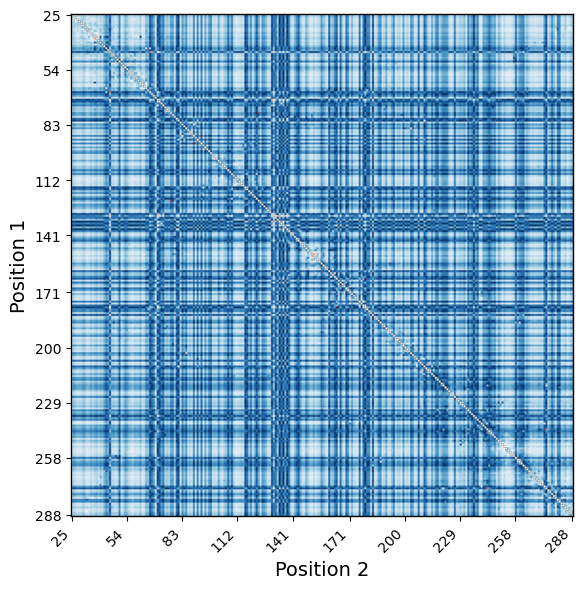

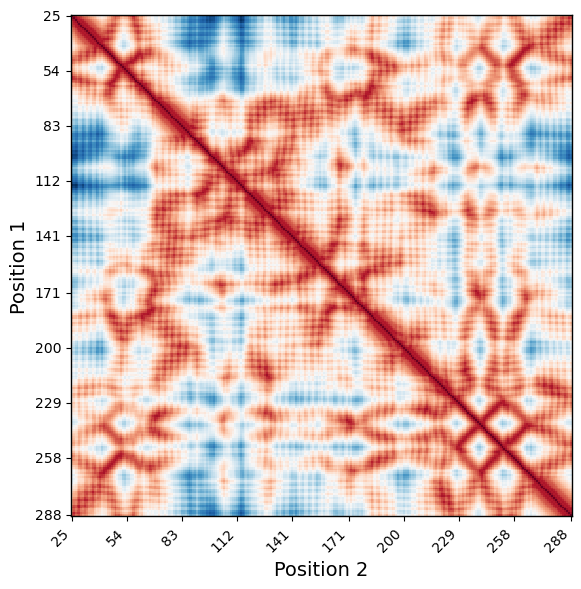

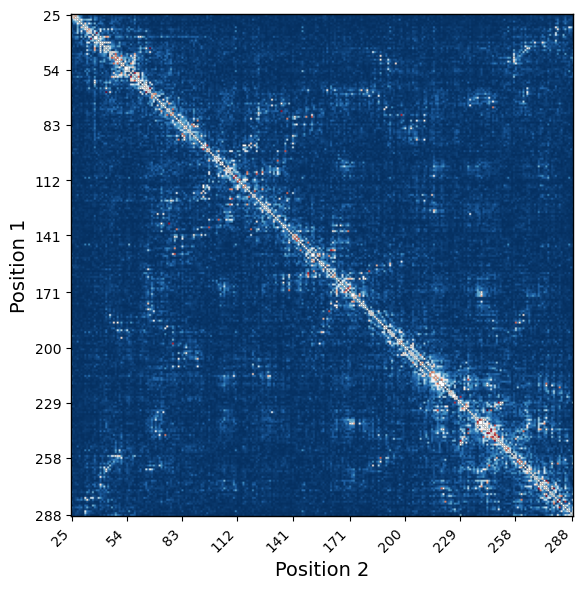

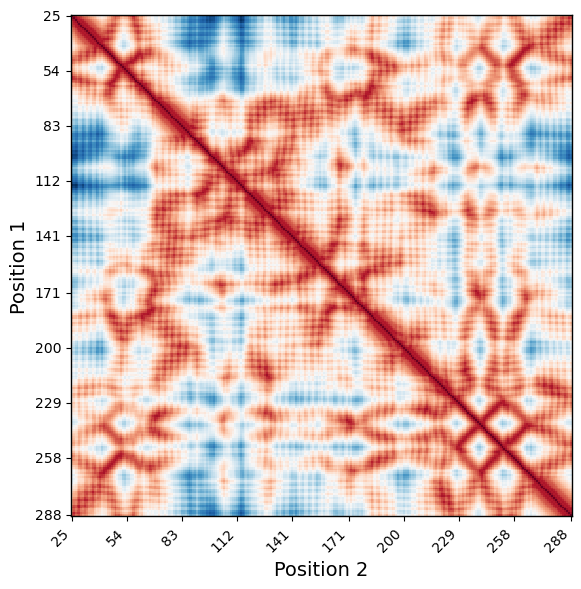

In [7]:
# Plot epistasis heatmaps and contact map
plot_heatmap_and_contact(epi_trans, dist_mat,
                         title='',
                         out_file=str(OUT_DIR / 'tem1_transformed'),
                         label_offset=LABEL_OFFSET, separate_figures=True,
                         show_cbar_epi=False, show_cbar_dist=False)

plot_heatmap_and_contact(epi_untrans, dist_mat,
                         title='',
                         vmax=0.95, 
                         # For YAP1 vmax=0.90
                         # For RRM2 vmax=0.80
                         # contract_ranges=None,
                         # For YAP1 contract_ranges=skip_ranges=[(.4,.6)]
                         # For RRM@ contract_ranges=[(0.3,0.4), (.5,.7)],
                         out_file=str(OUT_DIR / 'tem1_untransformed'),
                         label_offset=LABEL_OFFSET, separate_figures=True,
                         show_cbar_epi=False, show_cbar_dist=False)

Saved /Users/carlos/Desktop/evollm/paper_figs/tem1_transformed_independent.pdf


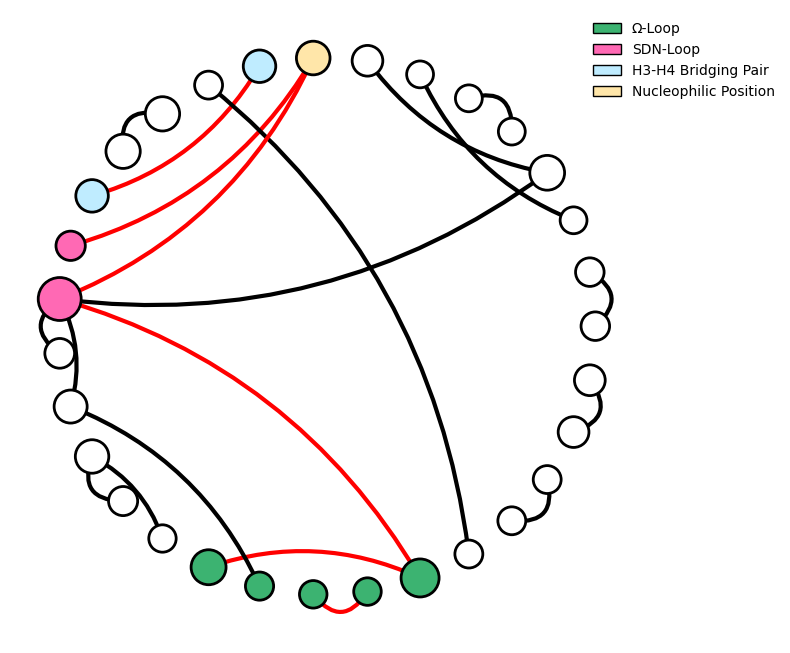

Saved /Users/carlos/Desktop/evollm/paper_figs/tem1_untransformed_independent.pdf


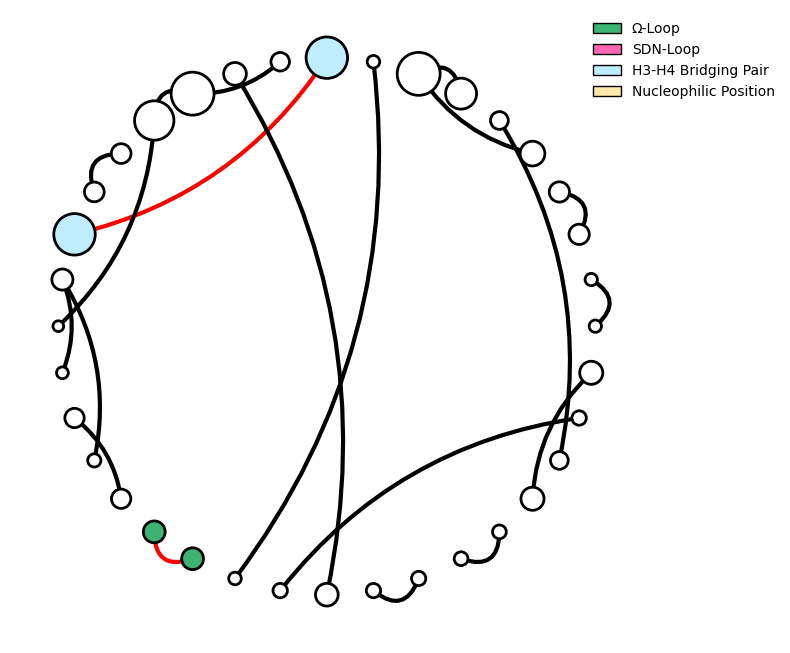

In [8]:
# Plot circular epistasis graphs
plot_circular_independent(
    epi_trans,
    top_n_edges=20,
    group_residues=[list(range(162,178)), [128,129,130], [75,121], [68]],
    group_colors=['#3CB371','#FF69B4','#BFECFF','#FFE6A9'],
    group_names=['Ω‑Loop','SDN‑Loop','H3‑H4 Bridging Pair','Nucleophilic Position'],
    show_only_group_labels=False,
    show_labels=False,
    highlight_group_edges=True,
    highlight_edge_color='#FF0000',
    rad=-0.2,
    rad_consec=0.7,
    node_size_min=0.05,
    node_size_max=0.08,
    font_size_min=10,
    font_size_max=17,
    edge_width=3,
    label_offset=LABEL_OFFSET,
    cmap_name='Greys',
    cmap_min_intensity=1,
    node_edge_width=2,
    output_prefix=str(OUT_DIR / 'tem1_transformed')
)

plot_circular_independent(
    epi_untrans,
    top_n_edges=20,
    group_residues=[list(range(162,178)), [128,129,130], [75,121], [68]],
    group_colors=['#3CB371','#FF69B4','#BFECFF','#FFE6A9'],
    group_names=['Ω‑Loop','SDN‑Loop','H3‑H4 Bridging Pair','Nucleophilic Position'],
    show_only_group_labels=False,
    show_labels=False,
    highlight_group_edges=True,
    highlight_edge_color='#FF0000',
    rad=-0.2,
    rad_consec=0.7,
    node_size_min=0.02,
    node_size_max=0.08,
    font_size_min=10,
    font_size_max=17,
    edge_width=3,
    label_offset=LABEL_OFFSET,
    cmap_name='Greys',
    cmap_min_intensity=1,
    node_edge_width=2,
    output_prefix=str(OUT_DIR / 'tem1_untransformed')
)